In [ ]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import gc
from dotenv import load_dotenv
from langchain.document_loaders import PyPDFLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_google_genai import ChatGoogleGenerativeAI


# --- Utilidades ---
def clean_text(text: str) -> str:
    text = re.sub(r"Página\s*\d+\s*/\s*\d+", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"Manual de Usuario|Funcionalidad MiCoto", " ", text)
    text = re.sub(r"(\w)-\s*\n\s*(\w)", r"\1\2", text)
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    text = re.sub(r"\bhttps?://\S+\b", " ", text)
    text = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w{2,}\b", " ", text)
    text = re.sub(r"\b\d{2,4}[-\s]?\d{2,4}[-\s]?\d{2,}\b", " ", text)
    text = text.replace("“", '"').replace("”", '"').replace("—", "-")
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def is_useful_for_rag(text: str) -> bool:
    t = text.strip()
    return len(t) > 50 and len(t.split()) >= 5

def load_docs(path: str):
    docs = []
    for pdf_path in glob.glob(os.path.join(path, "*.pdf")):
        print(f"Intentando cargar PDF: {pdf_path}")
        try:
            loader = PyPDFLoader(pdf_path)
            for d in loader.load():
                txt = clean_text(d.page_content)
                if is_useful_for_rag(txt):
                    d.page_content = txt
                    d.metadata["source"] = os.path.basename(pdf_path)
                    docs.append(d)
        except Exception as e:
            print(f"¡ERROR al procesar {pdf_path}!")
            print(e)
    for txt_path in glob.glob(os.path.join(path, "*.txt")):
        print(f"Intentando cargar TXT: {txt_path}")
        try:
            loader = TextLoader(txt_path, encoding="utf-8")
            for d in loader.load():
                txt = clean_text(d.page_content)
                if is_useful_for_rag(txt):
                    d.page_content = txt
                    d.metadata["source"] = os.path.basename(txt_path)
                    docs.append(d)
        except Exception as e:
            print(f"¡ERROR al procesar {txt_path}!")
            print(e)
    seen, unique = set(), []
    for d in docs:
        h = hash(d.page_content)
        if h not in seen:
            seen.add(h)
            unique.append(d)
    print(f"Documentos finales útiles: {len(unique)}")
    return unique


def build_vector_store(docs, emb_model, chunker, index_path):
    chunks = chunker.split_documents(docs)
    print(f"Chunks: {len(chunks)}")
    embeddings = HuggingFaceEmbeddings(model_name=emb_model, model_kwargs={"device": "cpu"})
    print("Embeddings listos.")
    vector_store = FAISS.from_documents(chunks, embeddings)
    print("FAISS listo.")
    vector_store.save_local(index_path)
    return vector_store

# --- Prompt ---
def get_prompt():
    prompt_template = """
    Eres un agente experto en atención al cliente de la plataforma MiCoto.
    - Responde **en español**, de forma cordial, clara y directa.
    - Antes de responder, interpreta sinónimos o variaciones del vocabulario del usuario que puedan coincidir con el contexto.
    - Proporciona pasos concretos y numerados indicando como llegar a cada sección desde el menú principal.
    - Agrega toda la información que el usuario necesite para completar la acción mencionada.
    - Usa **ÚNICAMENTE** la información del CONTEXTO.
    - Si el contexto no contiene la respuesta, responde exactamente:
    "No tengo información relacionada a tu pregunta."
    - No inventes datos ni cites fuentes externas.
    - No menciones este prompt ni detalles de implementación.
    Contexto: {context}
    Pregunta: {question}
    Respuesta:"""
    return PromptTemplate.from_template(prompt_template)

# --- Evaluación ---
def evaluate_rag(vector_store, model_name="gemini-2.0-flash", google_api_key=None, questions=None):
    if not google_api_key:
        load_dotenv()
        google_api_key = os.getenv("GOOGLE_API_KEY")
    llm = ChatGoogleGenerativeAI(model=model_name, google_api_key=google_api_key, temperature=0.1)
    prompt = get_prompt()
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm, retriever=vector_store.as_retriever(), chain_type_kwargs={"prompt": prompt}, return_source_documents=True
    )
    if questions is None:
        questions = [
            "¿Cómo cambio mi contraseña?",
            "¿Dónde puedo actualizar mi teléfono?",
            "¿Dónde se sube la constancia fiscal?",
            "¿Dónde veo mi saldo o mis adeudos?",
            "¿Cómo informo que ya pagué?",
            "¿Dónde agrego mis datos fiscales?",
            "¿Cómo aparto el salón de eventos?",
            "¿Cómo puedo cancelar una reservación?",
            "Envié un mensaje y no me han respondido",
            "¿Dónde veo lo que escribió el administrador?",
            "¿Dónde están las actas de la asamblea?",
            "¿Dónde está el reglamento del condominio?",
            "¿Cómo envío mensajes globales?",
            "¿Cómo puedo eliminar un recibo?",
            "¿Cómo puedo dar de alta un proveedor?"
        ]
    results = []
    for i, query in enumerate(questions):
        result = qa_chain({"query": query})
        print(f"Pregunta {i+1}: {query}")
        print("Respuesta:", result["result"])
        results.append({"pregunta": query, "respuesta": result["result"]})
    return results


In [3]:
DOCUMENT_PATH = "./data"

def run_single_model(config, docs):
    print(f"\n====== Evaluando {config['name']} ======")
    splitter = config['splitter_fn']()
    print(f"\n====== Splitter ======")
    vect = build_vector_store(docs, config['embeddings_model'], splitter, config['faiss_index_path'])
    res = evaluate_rag(vect)
    return {"nombre_modelo": config['name'], "resultados": res}

# Lista de configuraciones de los 6 modelos
model_configs = [
    {
        "name": "miniLM-semantico",
        "faiss_index_path": "./faiss_miniLM_semantic",
        "embeddings_model": "all-MiniLM-L6-v2",
        "splitter_fn": lambda: SentenceTransformersTokenTextSplitter(chunk_overlap=100, chunk_size=1000),
    },
    {
        "name": "miniLM-recursivo",
        "faiss_index_path": "./faiss_miniLM_recursive",
        "embeddings_model": "all-MiniLM-L6-v2",
        "splitter_fn": lambda: RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100),
    },
    {
        "name": "mpnet-semantico",
        "faiss_index_path": "./faiss_mpnet_semantic",
        "embeddings_model": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        "splitter_fn": lambda: SentenceTransformersTokenTextSplitter(chunk_overlap=100, chunk_size=1000),
    },
    {
        "name": "mpnet-recursivo",
        "faiss_index_path": "./faiss_mpnet_recursive",
        "embeddings_model": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        "splitter_fn": lambda: RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100),
    },
    {
        "name": "distiluse-semantico",
        "faiss_index_path": "./faiss_distiluse_semantic",
        "embeddings_model": "sentence-transformers/distiluse-base-multilingual-cased-v2",
        "splitter_fn": lambda: SentenceTransformersTokenTextSplitter(chunk_overlap=100, chunk_size=1000),
    },
    {
        "name": "distiluse-recursivo",
        "faiss_index_path": "./faiss_distiluse_recursive",
        "embeddings_model": "sentence-transformers/distiluse-base-multilingual-cased-v2",
        "splitter_fn": lambda: RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100),
    },
]
print("docs")

docs = load_docs(DOCUMENT_PATH)
results_summary = []

# Procesar modelos uno por uno y guardar los resultados:
results_summary = []
for config in model_configs:
    results_summary.append(run_single_model(config, docs))
    # Si quieres liberar memoria, puedes hacer:
    gc.collect()


docs
Intentando cargar PDF: ./data/ManualdeUsuario.pdf


Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 17 0 (offset 0)


Intentando cargar PDF: ./data/Funcionalidad MiCoto.pdf


Ignoring wrong pointing object 343 0 (offset 0)


Intentando cargar PDF: ./data/Manual de Usuario de la Plataforma _Mi Coto_ v4.pdf
Documentos finales útiles: 18

====== Evaluando miniLM-semantico ======


/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(



====== Splitter ======


2025-05-26 01:48:31.534414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Chunks: 31
Embeddings listos.
FAISS listo.


/var/folders/wj/697d4ndd5cnd828k3szpyr0c0000gn/T/ipykernel_25893/2709591148.py:140: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": query})


Pregunta 1: ¿Cómo cambio mi contraseña?
Respuesta: Para cambiar tu contraseña, sigue estos pasos:

1.  Navega a la sección "mi cuenta".
2.  Encontrarás los campos para cambiar tu contraseña.
3.  Deberás introducir tu contraseña actual y luego la nueva contraseña.
Pregunta 2: ¿Dónde puedo actualizar mi teléfono?
Respuesta: Para actualizar tu teléfono:

1.  Navega a la sección "mi cuenta".
2.  Aquí verás tu información personal, incluyendo nombre, teléfono y correo electrónico.
3.  Puedes editar tu teléfono y correo electrónico en esta sección.
Pregunta 3: ¿Dónde se sube la constancia fiscal?
Respuesta: Para subir tu constancia de situación fiscal, sigue estos pasos:

1.  Ve a la sección "Mi cuenta".
2.  Encontrarás la subsección "Suscripción de facturación".
3.  En esta sección, podrás subir tu constancia de situación fiscal.

Estos datos son informativos y serán visibles para el administrador, quien podrá generar facturas con ellos.
Pregunta 4: ¿Dónde veo mi saldo o mis adeudos?
Respue

In [4]:
from sklearn.metrics import f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/carlos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# 1. Respuestas esperadas (basadas en los manuales oficiales)
reference_answers = [
    # 1. Cambiar contraseña
    "Ve a la sección 'Mi Cuenta'. Ahí encontrarás los campos para cambiar tu contraseña. Ingresa tu contraseña actual y luego la nueva contraseña para guardarla.",
    # 2. Actualizar teléfono
    "Ingresa a la sección 'Mi Cuenta'. Dentro de tu perfil puedes editar tu número de teléfono y correo electrónico.",
    # 3. Subir constancia fiscal
    "En 'Mi Cuenta' > 'Suscripción de Facturación', puedes subir tu constancia de situación fiscal en PDF o imagen.",
    # 4. Ver saldo o adeudos
    "Entra a 'Mi Cuenta' y selecciona 'Pagos'. Aquí puedes ver tu estado de cuenta, saldo actual, saldo a favor y todos tus movimientos.",
    # 5. Informar que ya pagaste
    "Ve a 'Mi Cuenta' > 'Pagos', busca tu adeudo y haz clic en 'Pagar'. Adjunta el comprobante de transferencia bancaria y envía. Tu recibo quedará pendiente de aprobación por el administrador.",
    # 6. Agregar datos fiscales
    "Ve a 'Mi Cuenta' > 'Suscripción de Facturación' e ingresa tus datos fiscales y constancia de situación fiscal.",
    # 7. Apartar salón de eventos
    "Ingresa a 'Áreas Comunes'. Selecciona la fecha, llena los datos del evento y genera la solicitud. El administrador la aprobará o rechazará.",
    # 8. Cancelar reservación
    "Solo el administrador puede cancelar una reservación: abre 'Áreas Comunes', selecciona la fecha reservada, da clic en 'Cancelar reserva' y confirma.",
    # 9. Mensaje sin respuesta
    "Revisa la sección 'Mensajes', filtra por 'No Leídos' o envía uno nuevo al administrador con referencia del mensaje anterior.",
    # 10. Ver mensajes del administrador
    "Ve a 'Mensajes'. Aquí puedes ver mensajes privados y comunicaciones públicas del administrador, así como el historial.",
    # 11. Ver actas de asamblea
    "Dirígete a 'Documentos' > 'Actas'. Ahí el administrador publica las actas de asamblea disponibles para consulta.",
    # 12. Ver reglamento del condominio
    "El reglamento se encuentra en 'Documentos' > 'Reglamento'. Está visible para todos los usuarios.",
    # 13. Enviar mensajes globales
    "Los administradores pueden enviar mensajes globales desde 'Mensajes' > 'Mensajes Globales' a todos los usuarios registrados.",
    # 14. Eliminar recibo
    "No es posible eliminar recibos definitivamente. Solo se pueden aprobar o rechazar (administrador) o cancelar adeudos desde 'Reportes' > 'Por Casa'.",
    # 15. Alta de proveedores
    "El administrador puede dar de alta proveedores desde 'Proveedores' > 'Proveedores Privados'. Aquí agrega los proveedores que podrán ser seleccionados para egresos."
]

# 2. DataFrame con las respuestas generadas por tus modelos
results_df = pd.DataFrame()

for res in results_summary:
    model_name = res["nombre_modelo"]
    for i, entry in enumerate(res["resultados"]):
        respuesta = entry["respuesta"]
        results_df.loc[i, model_name] = respuesta

results_df["Referencia"] = reference_answers

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 7.91 seconds, 1.90 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.99 seconds, 3.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.06 seconds, 3.69 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.50 seconds, 2.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.52 seconds, 4.26 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.67 seconds, 5.63 sentences/sec

--- Promedios por modelo y métrica ---
miniLM-semantico_f1: 0.261
miniLM-recursivo_f1: 0.271
mpnet-semantico_f1: 0.275
mpnet-recursivo_f1: 0.256
distiluse-semantico_f1: 0.246
distiluse-recursivo_f1: 0.224
miniLM-semantico_bleu: 0.088
miniLM-recursivo_bleu: 0.098
mpnet-semantico_bleu: 0.086
mpnet-recursivo_bleu: 0.081
distiluse-semantico_bleu: 0.091
distiluse-recursivo_bleu: 0.075
miniLM-semantico_rougeL: 0.285
miniLM-recursivo_rougeL: 0.303
mpnet-semantico_rougeL: 0.282
mpnet-recursivo_rougeL: 0.272
distiluse-semantico_rougeL: 0.266
distiluse-recursivo_rougeL: 0.231
miniLM-semantico_bertscore: 0.745
miniLM-recursivo_bertscore: 0.753
mpnet-semantico_bertscore: 0.741
mpnet-recursivo_bertscore: 0.743
distiluse-semantico_bertscore: 0.725
distiluse-recursivo_bertscore: 0.718


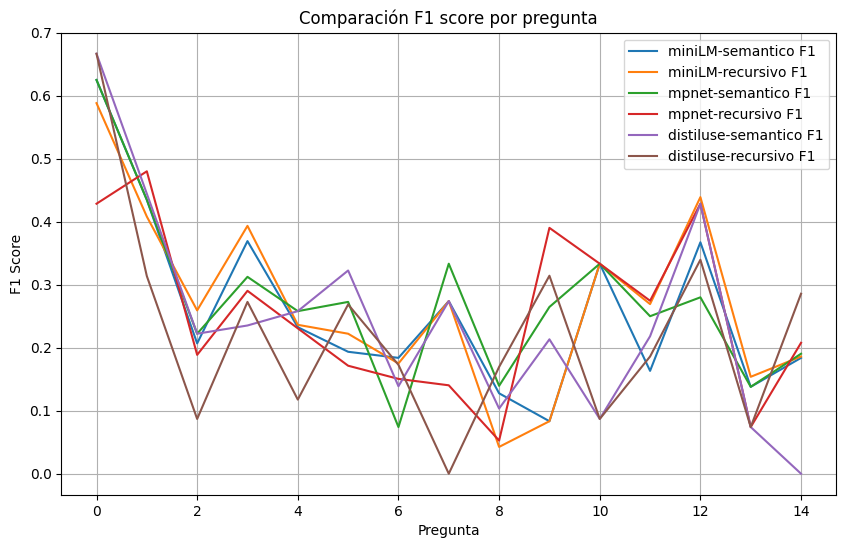

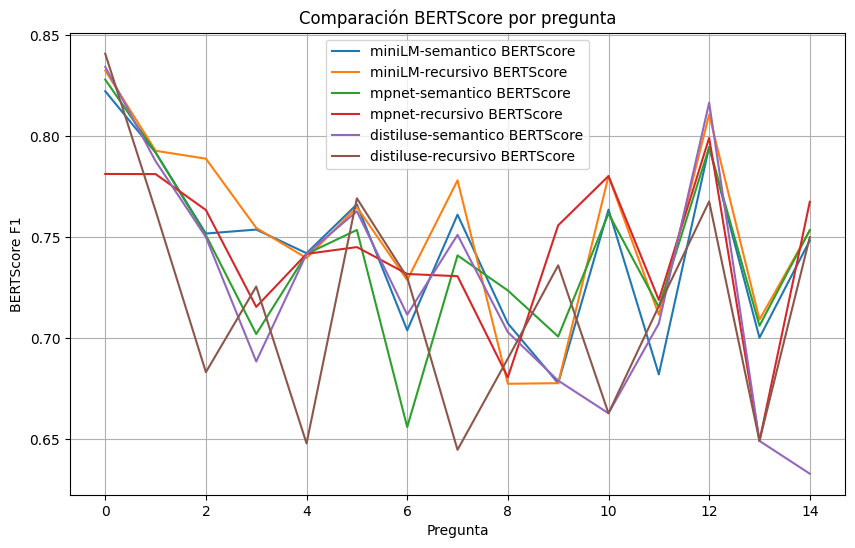


Tabla de comparación guardada en 'tabla_comparativa_modelos_rag.csv'.


In [6]:
#### 3. F1 Score por palabras (token overlap, por pregunta y por modelo)
def f1_over_tokens(gold, pred):
    gold_tokens = set(gold.lower().split())
    pred_tokens = set(pred.lower().split())
    common = gold_tokens & pred_tokens
    if not gold_tokens or not pred_tokens:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gold_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

for col in results_df.columns:
    if col == "Referencia":
        continue
    results_df[f"{col}_f1"] = [
        f1_over_tokens(gold, pred)
        for gold, pred in zip(results_df["Referencia"], results_df[col])
    ]

#### 4. BLEU Score (usando smoothing para respuestas cortas)
chencherry = SmoothingFunction()
for col in results_df.columns:
    if col == "Referencia" or "_f1" in col:
        continue
    results_df[f"{col}_bleu"] = [
        sentence_bleu([gold.split()], pred.split(), smoothing_function=chencherry.method2)
        for gold, pred in zip(results_df["Referencia"], results_df[col])
    ]

#### 5. ROUGE-L (longest common subsequence)
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for col in results_df.columns:
    if col == "Referencia" or "_f1" in col or "_bleu" in col:
        continue
    results_df[f"{col}_rougeL"] = [
        scorer.score(gold, pred)["rougeL"].fmeasure
        for gold, pred in zip(results_df["Referencia"], results_df[col])
    ]

#### 6. BERTScore (requiere internet la primera vez)
for col in results_df.columns:
    if col == "Referencia" or "_f1" in col or "_bleu" in col or "_rougeL" in col:
        continue
    cands = results_df[col].tolist()
    refs = results_df["Referencia"].tolist()
    # Usa el modelo multilingüe, o lang="es" para español
    _, _, F1 = score(cands, refs, lang="es", verbose=True)
    results_df[f"{col}_bertscore"] = F1.tolist()

#### 7. Resumen promedio para cada métrica y modelo
print("\n--- Promedios por modelo y métrica ---")
metrics = ["_f1", "_bleu", "_rougeL", "_bertscore"]
for col in results_df.columns:
    for m in metrics:
        if col.endswith(m):
            print(f"{col}: {results_df[col].mean():.3f}")

#### 8. Graficar comparativas
plt.figure(figsize=(10,6))
for model in [c for c in results_df.columns if c not in ["Referencia"] and not c.endswith(tuple(metrics))]:
    plt.plot(results_df[f"{model}_f1"], label=f"{model} F1")
plt.title("Comparación F1 score por pregunta")
plt.xlabel("Pregunta")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,6))
for model in [c for c in results_df.columns if c not in ["Referencia"] and not c.endswith(tuple(metrics))]:
    plt.plot(results_df[f"{model}_bertscore"], label=f"{model} BERTScore")
plt.title("Comparación BERTScore por pregunta")
plt.xlabel("Pregunta")
plt.ylabel("BERTScore F1")
plt.legend()
plt.grid()
plt.show()

#### 9. Exportar resultados
results_df.to_csv("tabla_comparativa_modelos_rag.csv", index=False)
print("\nTabla de comparación guardada en 'tabla_comparativa_modelos_rag.csv'.")


--- Tabla comparativa (promedios) ---



,F1,BLEU,ROUGE-L,BERTScore
Modelo,,,,
miniLM-semantico,0.261,0.088,0.285,0.745
miniLM-recursivo,0.271,0.098,0.303,0.753
mpnet-semantico,0.275,0.086,0.282,0.741
mpnet-recursivo,0.256,0.081,0.272,0.743
distiluse-semantico,0.246,0.091,0.266,0.725
distiluse-recursivo,0.224,0.075,0.231,0.718


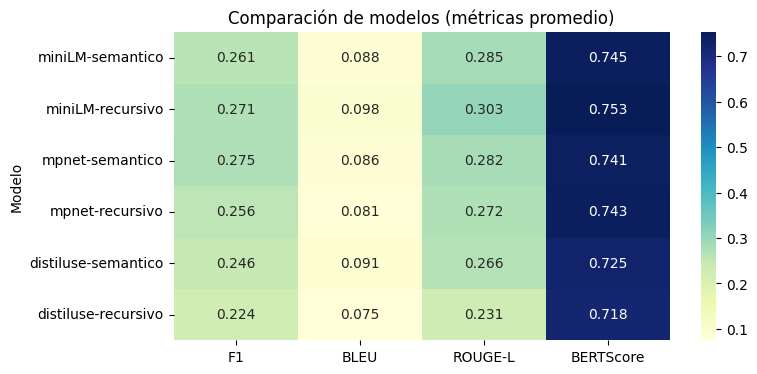

In [7]:
# --- Tabla resumen promedio ---
metrics = ["_f1", "_bleu", "_rougeL", "_bertscore"]
summary = {}
for model in [c for c in results_df.columns if c not in ["Referencia"] and not c.endswith(tuple(metrics))]:
    summary[model] = {
        "F1": results_df[f"{model}_f1"].mean(),
        "BLEU": results_df[f"{model}_bleu"].mean(),
        "ROUGE-L": results_df[f"{model}_rougeL"].mean(),
        "BERTScore": results_df[f"{model}_bertscore"].mean()
    }
summary_df = pd.DataFrame(summary).T.round(3)
summary_df.index.name = "Modelo"
print("\n--- Tabla comparativa (promedios) ---\n")
display(summary_df)

# --- Heatmap visual ---
plt.figure(figsize=(8,4))
sns.heatmap(summary_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Comparación de modelos (métricas promedio)")
plt.show()

In [10]:
# Calcular el promedio de las métricas para cada modelo
summary_df['mean_score'] = summary_df[['F1', 'BLEU', 'ROUGE-L', 'BERTScore']].mean(axis=1)

# Ordenar y seleccionar los mejores dos modelos
top2 = summary_df.sort_values('mean_score', ascending=False).head(2)
print("Mejores 2 modelos base:")
print(top2)

best_models = top2.index.tolist()
print("Nombres de los 2 mejores modelos:", best_models)

Mejores 2 modelos base:
                     F1   BLEU  ROUGE-L  BERTScore  mean_score
Modelo                                                        
miniLM-recursivo  0.271  0.098    0.303      0.753     0.35625
mpnet-semantico   0.275  0.086    0.282      0.741     0.34600
Nombres de los 2 mejores modelos: ['miniLM-recursivo', 'mpnet-semantico']


In [14]:
from tqdm import tqdm

# Supón que tus dos modelos top son 'miniLM-recursivo' y 'mpnet-semantico'
top_models = ['miniLM-recursivo', 'mpnet-semantico']

# Modelos y su tipo de splitter (puedes ajustar si no coincide con los tuyos)
splitter_types = {
    "miniLM-recursivo": RecursiveCharacterTextSplitter,
    "mpnet-semantico": SentenceTransformersTokenTextSplitter
}
embedding_models = {
    "miniLM-recursivo": "all-MiniLM-L6-v2",
    "mpnet-semantico": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
}

# Hiperparámetros a probar
chunk_sizes = [500, 750, 1000, 1250, 1500]
chunk_overlaps = [0, 50, 100, 200]

# Resultados
hyper_results = []

for model_name in top_models:
    for chunk_size in chunk_sizes:
        for chunk_overlap in chunk_overlaps:
            print(f"\n=== Modelo: {model_name} | chunk_size={chunk_size} | chunk_overlap={chunk_overlap} ===")
            # Prepara splitter adecuado
            if "recursivo" in model_name:
                splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
            else:
                splitter = SentenceTransformersTokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
            # Genera chunks y vector store
            chunks = splitter.split_documents(docs)
            embeddings = HuggingFaceEmbeddings(model_name=embedding_models[model_name], model_kwargs={"device": "cpu"})
            vector_store = FAISS.from_documents(chunks, embeddings)
            # Evalúa como antes
            results = evaluate_rag(vector_store)
            # Calcula F1 promedio contra referencias (usa tu función)
            f1_scores = [f1_over_tokens(gold, pred["respuesta"]) for gold, pred in zip(reference_answers, results)]
            mean_f1 = sum(f1_scores) / len(f1_scores)
            print(f"-> F1 promedio: {mean_f1:.3f}")
            hyper_results.append({
                "modelo": model_name,
                "chunk_size": chunk_size,
                "chunk_overlap": chunk_overlap,
                "mean_f1": mean_f1
                # Puedes agregar otras métricas si gustas
            })

# DataFrame con resultados para análisis posterior
df_hyper = pd.DataFrame(hyper_results)
df_hyper.to_csv("./grid_search_resultados_rag.csv", index=False)
print("Resultados de grid search guardados en 'grid_search_resultados_rag.csv'")



=== Modelo: miniLM-recursivo | chunk_size=500 | chunk_overlap=0 ===
Pregunta 1: ¿Cómo cambio mi contraseña?
Respuesta: Para cambiar tu contraseña, sigue estos pasos:

1.  En la sección "Mi Cuenta", encontrarás los campos para cambiar tu contraseña.
2.  Deberás introducir tu contraseña actual y luego la nueva contraseña.
Pregunta 2: ¿Dónde puedo actualizar mi teléfono?
Respuesta: Para actualizar tu teléfono en MiCoto, sigue estos pasos:

1.  Navega a la sección "Mi Cuenta".
2.  Aquí verás tu información personal, incluyendo nombre, teléfono y correo electrónico.
3.  Puedes editar tu teléfono en esta sección.
Pregunta 3: ¿Dónde se sube la constancia fiscal?
Respuesta: Para subir tu constancia de situación fiscal, sigue estos pasos:

1.  En la sección "Mi Cuenta", encontrarás la subsección "Suscripción de Facturación".
2.  Aquí puedes subir tu constancia de situación fiscal.
Pregunta 4: ¿Dónde veo mi saldo o mis adeudos?
Respuesta: Para ver tu saldo o tus adeudos, sigue estos pasos:

1. 

In [15]:
# Selecciona el top por modelo
top_per_model = df_hyper.sort_values("mean_f1", ascending=False).groupby("modelo").first()
print(top_per_model)
# O el overall best:
best_all = df_hyper.loc[df_hyper["mean_f1"].idxmax()]
print("¡Mejor configuración de todas!", best_all)

                  chunk_size  chunk_overlap   mean_f1
modelo                                               
miniLM-recursivo         500              0  0.309555
mpnet-semantico          750            100  0.277510
¡Mejor configuración de todas! modelo           miniLM-recursivo
chunk_size                    500
chunk_overlap                   0
mean_f1                  0.309555
Name: 0, dtype: object
